<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-2/blob/master/Parte_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Diseño e implementación detallado de Redes Recurrentes (RNN) y sus derivados.
* Compuertas LSTM y GRU. 
* Arquitectura Encoder-Decoder para problemas de *traducción*.
* Arquitectura de Autoencoder para reducción de dimensionalidad.
* Modelos generativos profundos: VAEs (*Variational Autoencoder*)

** Formalidades **  
* Equipos de trabajo de: 2-3 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: por definir.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2019]

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[0+.](#bonus) Bonus  
[1.](#primero) RNN sobre texto  
[2.](#segundo) *Encoder-Decoder* sobre imágenes    
[3.](#tercero) *Encoder-Decoder* sobre Texto    
[4.](#cuarto) Distintos tipos de autoencoders (AEs) en MNIST    

[texto del vínculo](https:// [texto del vínculo](https://))<a id="cuarto"></a>
## 4. Distintos tipos de autoencoders (AEs) en MNIST
---

Como se ha discutido en clases, las RBM’s y posteriormente los AE's (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. Recientemente se ha propuesto AE's con distribuciones de probabilidades en su codificación, VAE [[7]](#refs). Los VAE son una variación bayesiana que aprende los parámetros de alguna distribución de probabilidad de variables latentes definida sobre los datos, a través de esa variable latente el decodificador generar/reconstruye nuevos datos $\hat{x}$. En resumidas cuentas, es un autoencoder que aprende un modelo sobre las variables latentes de los datos.

<img src="https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png" title="mnist" width="25%" style="float: right;" />

Con este objetivo en mente, utilizaremos un dataset simple denominado **MNIST**. Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes



Cargue los datos desde el repositorio de Keras.


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import keras
import keras.backend as K
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train[:,:,:,None] #add channels
X_test = X_test[:,:,:,None]
img_rows, img_cols,channel = X_train.shape[1:]
original_img_size = (img_rows, img_cols, channel) # input image dimensions

Using TensorFlow backend.


a) Normalice las imágenes de modo que los pixeles queden en el rango [0, 1] como se acostumbra al trabajar con imágenes. Visualice y comente sobre los datos a trabajar.

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

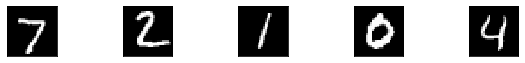

In [4]:
n = 5
plt.figure(figsize=(10, 2))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
X_train = X_train.astype('float32') / 255. 
X_test = X_test.astype('float32') / 255.

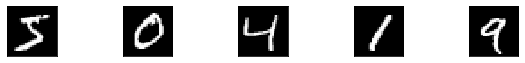

In [6]:
n = 5
plt.figure(figsize=(10, 2))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_train[i].reshape(28, 28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### 4.1 Autoencoder clásico
Una de las aplicaciones tı́picas de un AE es **reducción de dimensionalidad**, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.


<img src="https://miro.medium.com/max/1400/0*yGqTBMopqHbR0fcF." title="AE" width="50%" />


a) Entrene un AE básico, 1 capa escondida *feed forward*, para generar una representación de MNIST en $d'= 2, 8, 16, 32$ dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación **ReLU** para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?

Se ejecutaran distintos autoencoders básicos con las distintas mediciones, además de usar tanto la función sigmoidal y ReLu en la activación del Encoder. No es posible usar la función ReLu en el Decoder, ya que podría generar pixeles con un valor mayor a 1 los cuales excederían al rango entre $[0,1]$ de los píxeles generado con la normalización previa.

Se verá más adelante de forma visual las mejoras que genera una función de activación ReLu para el Encoder, 

In [0]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
from keras.models import load_model
import pickle

In [0]:
def basic_autoencoder(compres_dim, activation_encoder, activation_decoder, loss):
  input_img = Input(shape=original_img_size)
  input_fl = Flatten()(input_img) #to get a vector representation
  encoded = Dense( compres_dim, activation = activation_encoder )( input_fl )
  decoded = Dense(np.prod(original_img_size), activation = activation_decoder )( encoded )
  decoded = Reshape(original_img_size)(decoded)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  autoencoder.compile(optimizer='rmsprop', loss = loss)
  fited = autoencoder.fit(X_train, X_train, epochs=40, batch_size=32, validation_data=(X_test, X_test), verbose = 0)
  return autoencoder, encoder, fited

In [0]:
def execute_and_save(dimensions, activation_encoder, activation_decoder, loss):
  histogram = []
  for x in dimensions:
    autoencoder, encoder, fited = basic_autoencoder(x, activation_encoder, activation_decoder, loss)
    histogram.append(fited)
    autoencoder.save('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/autoencoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
    encoder.save('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/encoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
  return histogram

In [0]:
sigmoid_sigmoid = execute_and_save([2,8,16,32], 'sigmoid', 'sigmoid', 'binary_crossentropy')

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/sigmoid_sigmoid.pickle', 'wb') as f:
    pickle.dump(sigmoid_sigmoid, f)

In [0]:
relu_sigmoid = execute_and_save([2,8,16,32], 'relu', 'sigmoid', 'binary_crossentropy')

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/relu_sigmoid.pickle', 'wb') as f:
    pickle.dump(relu_sigmoid, f)

Debido al tiempo que tomo realizar cada entrenamiento se decidió guardar cada uno de los archivos tanto de autoencoder como de encoder para ser utilizados en las siguientes secciones tales como la sección b) y c) de esta parte. Al igual que las variables de cada fit de los autoencoders.

 b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.

In [0]:
def show_number_by_file(loss, activation_encoder, x):
  autoencoder = load_model('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/autoencoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
  encoder = load_model('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/encoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
  decoded_test = autoencoder.predict(X_test)
  encoded_test = encoder.predict(X_test)
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(X_test[i].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

W0806 04:30:46.790912 140108490332032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 04:30:46.827061 140108490332032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 04:30:46.885792 140108490332032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0806 04:30:46.887511 140108490332032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0806 04:30:46.888565 140108490332032 depre

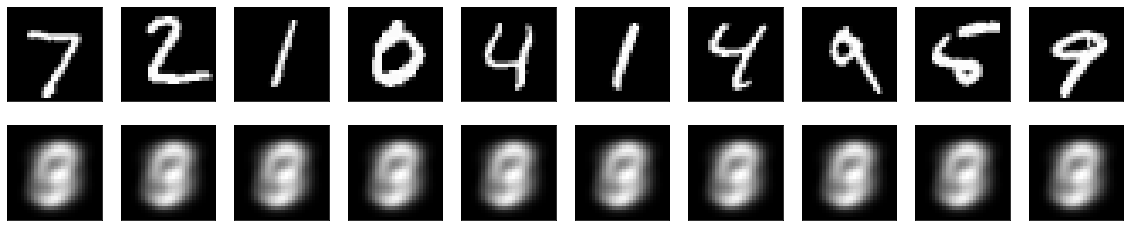

In [11]:
show_number_by_file('binary_crossentropy', 'sigmoid', 2)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


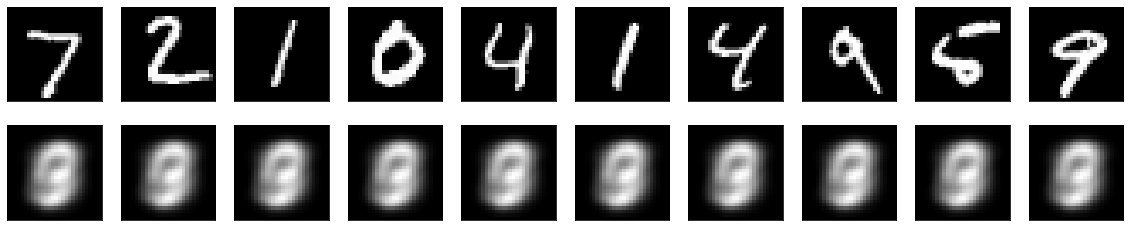

In [12]:
show_number_by_file('binary_crossentropy', 'sigmoid', 8)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


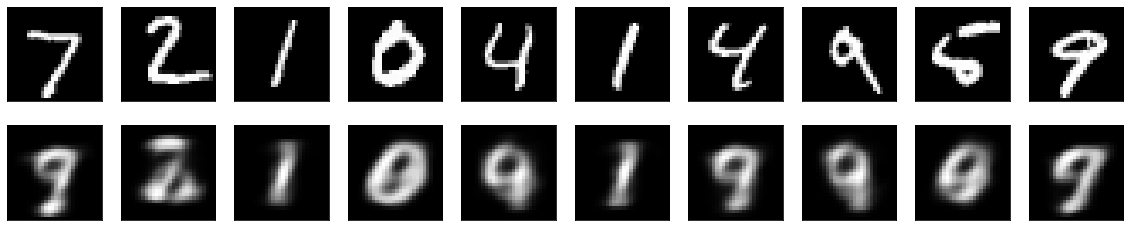

In [13]:
show_number_by_file('binary_crossentropy', 'sigmoid', 16)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


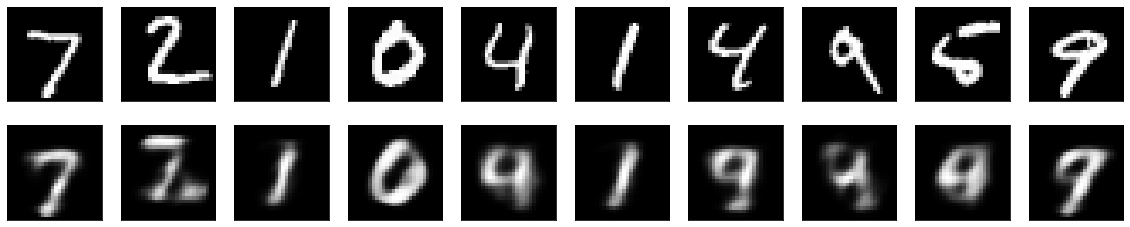

In [14]:
show_number_by_file('binary_crossentropy', 'sigmoid', 32)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


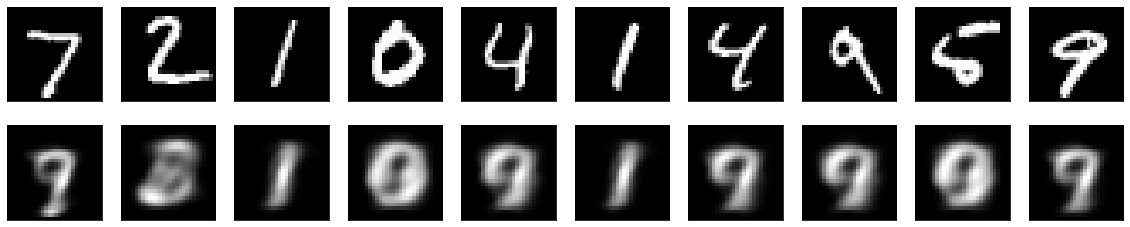

In [15]:
show_number_by_file('binary_crossentropy', 'relu', 2)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


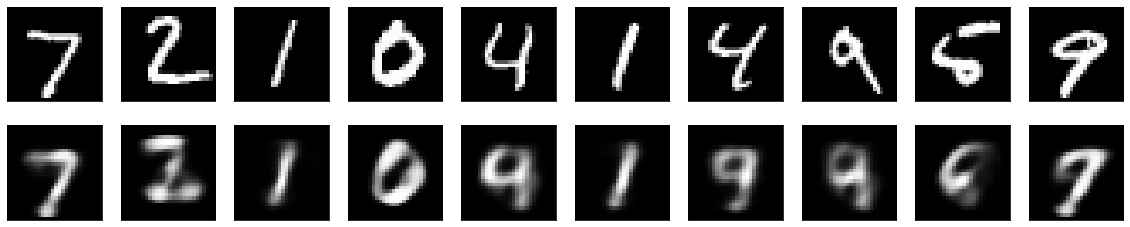

In [16]:
show_number_by_file('binary_crossentropy', 'relu', 8)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


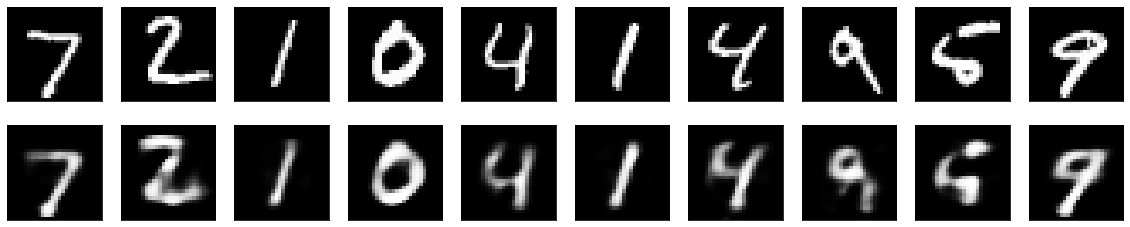

In [17]:
show_number_by_file('binary_crossentropy', 'relu', 16)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


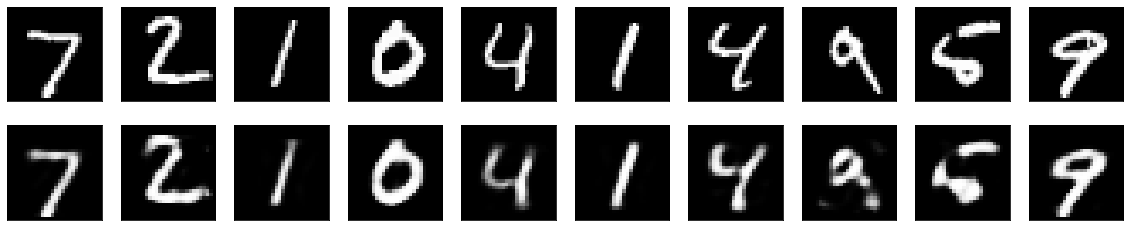

In [18]:
show_number_by_file('binary_crossentropy', 'relu', 32)

Cualitativamente es posible apreciar que las redes con mejores resultados son las que poseen la función de activación ReLu, y dentro de ellas son las con un $d'=16$ y $d'=32$ las que obtinenen los mejores resultados al clasificar los datos de test.


c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error, en conjunto de entrenamiento y pruebas, obtenido construyendo este clasificador sobre la data reducida a través del autoencoder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación, además de comparar los tiempos medios de predicción en ambos escenarios.

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [0]:
def apply_pca(n_components, loss, activation_encoder, x):
  pca = PCA(n_components = n_components)
  X_train_PCA = X_train.reshape((len(X_train), img_rows * img_cols * channel))
  X_test_PCA = X_test.reshape((len(X_test), img_rows * img_cols * channel))
  pca.fit(X_train_PCA)
  pca_train = pca.transform(X_train_PCA)
  pca_test = pca.transform(X_test_PCA)
  
  encoder = load_model('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/encoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
  encoded_train = encoder.predict(X_train)
  encoded_test = encoder.predict(X_test)
  
  clf = KNeighborsClassifier(10) #CLASIFICATION
  clf.fit(pca_train, Y_train)
  print('Classification Accuracy PCA %.2f' % clf.score(pca_test, Y_test))

  clf = KNeighborsClassifier(10) #CLASIFICATION
  clf.fit(encoded_train, Y_train)
  print('Classification Accuracy %.2f' % clf.score(encoded_test, Y_test))

A continuación se mostrará el Accuracy obtenido en el entrenamiento de PCA, además del Accuray de Test con el modelo de PCA, para cada dimensión distintas tanto para la función de activación sigmoidal como para la ReLu.

In [21]:
apply_pca(2, 'binary_crossentropy', 'sigmoid', 2)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.44
Classification Accuracy 0.10


In [22]:
apply_pca(8, 'binary_crossentropy', 'sigmoid', 8)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.90
Classification Accuracy 0.11


In [23]:
apply_pca(16, 'binary_crossentropy', 'sigmoid', 16)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.96
Classification Accuracy 0.70


In [24]:
apply_pca(32, 'binary_crossentropy', 'sigmoid', 32)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.97
Classification Accuracy 0.87


In [29]:
apply_pca(2, 'binary_crossentropy', 'relu', 2)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.44
Classification Accuracy 0.42


In [30]:
apply_pca(8, 'binary_crossentropy', 'relu', 8)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.90
Classification Accuracy 0.90


In [31]:
apply_pca(16, 'binary_crossentropy', 'relu', 16)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.96
Classification Accuracy 0.95


In [28]:
apply_pca(32, 'binary_crossentropy', 'relu', 32)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.97
Classification Accuracy 0.97


d) Modifique el autoencoder básico construido en (a) para implementar un *deep autoencoder* (más de dos capas) haciendo uso de las capas convolucionales para trabajar sobre matrices. Comente cómo sufre las transformaciones el patrón de entrada. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA y por el obtenido en (a) utilizando el mismo número de dimensiones $d'$ . Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPooling2D, UpSampling2D

In [0]:
def deep_autoencoder(latent_dim, activation_encoder, activation_decoder, loss):
  input_img = Input(shape=original_img_size)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value)
  x = Flatten()(x)
  encoded = Dense(latent_dim, activation='relu')(x)
  x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
  x = Reshape(before_F_shape)(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img,outputs=encoded)
  autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
  autoencoder.summary()
  fited = autoencoder.fit(X_train,X_train,epochs=40,batch_size=32,validation_data=(X_test, X_test), verbose = 0)
  return autoencoder, encoder, fited

In [0]:
def deep_execute_and_save(dimensions, activation_encoder, activation_decoder, loss):
  histogram = []
  for x in dimensions:
    autoencoder, encoder, fited = deep_autoencoder(x, activation_encoder, activation_decoder, loss)
    histogram.append(fited)
    autoencoder.save('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/deep_autoencoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
    encoder.save('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/deep_encoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
  return histogram

In [46]:
deep_sigmoid_sigmoid = deep_execute_and_save([2,8,16,32], 'sigmoid', 'sigmoid', 'binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3138      
__________

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/deep_sigmoid_sigmoid.pickle', 'wb') as f:
    pickle.dump(deep_sigmoid_sigmoid, f)

In [70]:
deep_relu_sigmoid = deep_execute_and_save([2,8,16,32], 'relu', 'sigmoid', 'binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 3138      
__________

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/deep_relu_sigmoid.pickle', 'wb') as f:
    pickle.dump(deep_relu_sigmoid, f)

In [0]:
def apply_pca_to_deep(n_components, loss, activation_encoder, x):
  pca = PCA(n_components = n_components)
  X_train_PCA = X_train.reshape((len(X_train), img_rows * img_cols * channel))
  X_test_PCA = X_test.reshape((len(X_test), img_rows * img_cols * channel))
  pca.fit(X_train_PCA)
  pca_train = pca.transform(X_train_PCA)
  pca_test = pca.transform(X_test_PCA)
  
  encoder = load_model('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/deep_encoder_%s_%s_%s.h5' % (loss, activation_encoder, x))
  encoded_train = encoder.predict(X_train)
  encoded_test = encoder.predict(X_test)
  
  clf = KNeighborsClassifier(10) #CLASIFICATION
  clf.fit(pca_train, Y_train)
  print('Classification Accuracy PCA %.2f' % clf.score(pca_test, Y_test))

  clf = KNeighborsClassifier(10) #CLASIFICATION
  clf.fit(encoded_train, Y_train)
  print('Classification Accuracy %.2f' % clf.score(encoded_test, Y_test))

In [50]:
apply_pca_to_deep(2, 'binary_crossentropy', 'sigmoid', 2)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.44
Classification Accuracy 0.63


In [51]:
apply_pca_to_deep(8, 'binary_crossentropy', 'sigmoid', 8)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.90
Classification Accuracy 0.94


In [52]:
apply_pca_to_deep(16, 'binary_crossentropy', 'sigmoid', 16)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.96
Classification Accuracy 0.96


In [53]:
apply_pca_to_deep(32, 'binary_crossentropy', 'sigmoid', 32)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.97
Classification Accuracy 0.97


Respecto al inciso a) existe una mejora desde el primer número de dimensiones para la función de activación sigmoidal con una loss *binary cross entropy*

In [72]:
apply_pca_to_deep(2, 'binary_crossentropy', 'relu', 2)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.44
Classification Accuracy 0.10


In [73]:
apply_pca_to_deep(8, 'binary_crossentropy', 'relu', 8)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.90
Classification Accuracy 0.89


In [74]:
apply_pca_to_deep(16, 'binary_crossentropy', 'relu', 16)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.96
Classification Accuracy 0.97


In [75]:
apply_pca_to_deep(32, 'binary_crossentropy', 'relu', 32)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.97
Classification Accuracy 0.97


e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


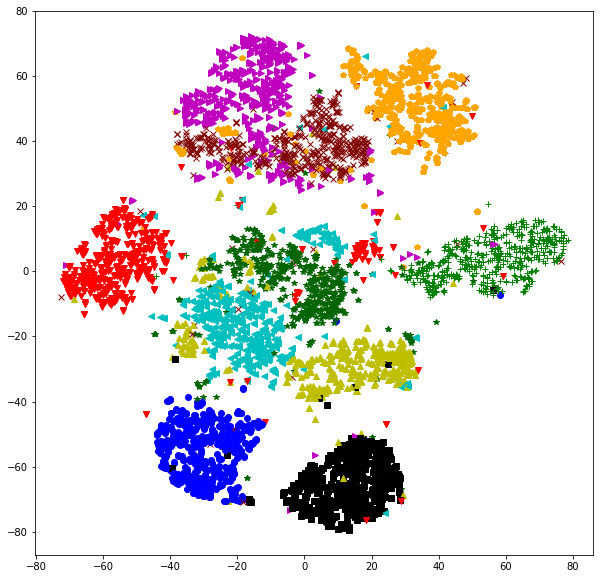

In [67]:
encoder = load_model('/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/autoencoders/deep_encoder_binary_crossentropy_sigmoid_32.h5')
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(X_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = Y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

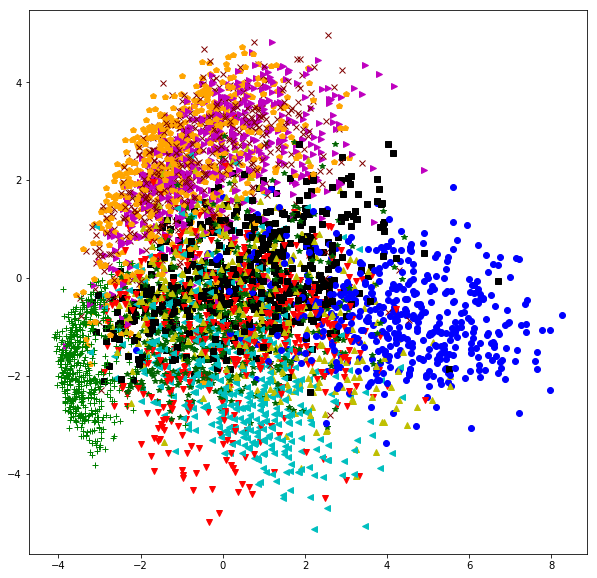

In [69]:
pca = PCA(n_components = 32)
X_train_PCA = X_train.reshape((len(X_train), img_rows * img_cols * channel))
X_test_PCA = X_test.reshape((len(X_test), img_rows * img_cols * channel))
pca.fit(X_train_PCA)
pca_train = pca.transform(X_train_PCA)

encoded_train = pca_train[:nplot]
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = Y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

### 4.2 Variational Autoencoder tradicional
El enfoque optimizador de los VAE sobre los parámetros modelados $\theta$ (decoder) y $\phi$ (encoder) que se deriva consta de minimizar la reconstrucción de los datos (al igual que un autoencoder tradicional), en base a alguna medicicón de error (*mse* por ejemplo) además de tener un factor de regularización que se impone para que la distribución aprendida de las variables latentes sea similar alguna distribución deseada *a priori*.  

$$ Min \ \mathcal{L}(p_{\theta}(x\mid z), \ x)\ +\ KL( q_{\phi}(z\mid x) \mid \mid p_{\theta}(z))$$

Con $\mathcal{L}$ la función de pérdida de reconstrucción, $KL$ la *KL Divergence* [[8]](#refs), $q_{\phi}(z \mid x)$ la codificación del dato a la variable latente $z$, $p_{\theta}(x\mid z)$ la recontrucción de los datos a través de las variables latentes $z$ y  $p_{\theta}(z)$ una distribución *a priori* asignada. 

<img src="https://i.imgur.com/ZN6MyTx.png" title="VAE" width="60%" />

a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 tandas convolucionales y una *fully conected*, con una distribución Normal de 2 componentes para las variables latentes, $z \sim \mathcal{N} (\mu, \sigma^2 )$. Describa la arquitectura utilizada.

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 2
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
encoder = Model(x, z_mean) # build a model to project inputs on the latent space

b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y 3 tandas de la operación inversa a una convolución (**Convolución transpuesta** [[9]](#refs)), comente cómo ésta trabaja y cómo funcionan los parámetros de *stride*.

In [0]:
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

c) Defina la sección que conecta a estas dos partes a través de un muestreo explícito de la distribución Normal (con $\epsilon \sim \mathcal{N}(0,1)$ se tiene $g = \mu + \sigma \cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilístico/bayesiano. Describa el modelo completo.

In [58]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_29[0][0]                  
__________________________________________________________________________________________________
flatten_7 

d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

In [59]:
from keras import backend as K # Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_29[0][0]                  
__________________________________________________________________________________________________
flatten_7 

e) Entrene el modelo definido con los datos de MNIST entre 20 a 30 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

In [60]:
batch_size = 100
epochs =  25
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 21s 349us/step - loss: 339453.6575 - val_loss: 41.4224
Epoch 2/25
60000/60000 [==============================] - 20s 329us/step - loss: 39.4410 - val_loss: 38.1677
Epoch 3/25
60000/60000 [==============================] - 20s 331us/step - loss: 37.2005 - val_loss: 36.7460
Epoch 4/25
60000/60000 [==============================] - 20s 333us/step - loss: 36.0572 - val_loss: 35.3159
Epoch 5/25
60000/60000 [==============================] - 20s 330us/step - loss: 35.3589 - val_loss: 34.7309
Epoch 6/25
60000/60000 [==============================] - 20s 331us/step - loss: 34.8829 - val_loss: 34.5639
Epoch 7/25
60000/60000 [==============================] - 20s 332us/step - loss: 34.5197 - val_loss: 34.3894
Epoch 8/25
60000/60000 [==============================] - 20s 330us/step - loss: 34.2177 - val_loss: 34.1465
Epoch 9/25
60000/60000 [==============================] - 20s 331us/step -

 f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_i$, compare cualitativamente con la representación *TSNE* del AE tradicional. Además genere un histograma de la media y la varianza $\sigma_i^2$ de las dos componentes. Comente.

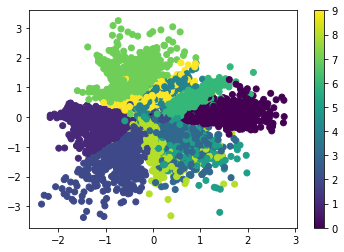

In [62]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
plt.colorbar()
plt.show() # display a 2D plot of the digit classes in the latent space

g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿Qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?

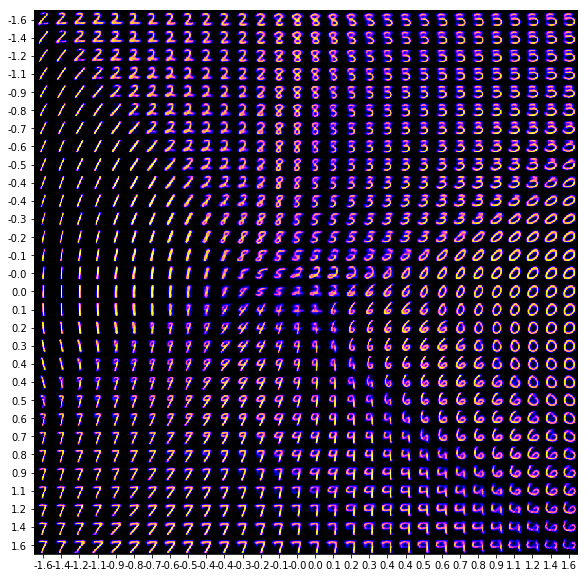

In [64]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza

h) Experimente y comente si mejora o empeora el desempeño de clasificación de la representación encontrada al aumentar la dimensionalidad de las variables latentes $z$, contrarrestándolo con el AE tradicional ($d' = 2,8,16,32 $). Explique.

### 4.3 Variational Autoencoder categórico

En esta última sección se explorará el caso en que se cambia el modelamiento sobre la variable latente a una distribuida Multinomial para representar una variable **categórica** que podría entregarnos cierta intuición de capturar las clases del problema de manera no supervisada. Para éste objetivo definiremos el número de variables latentes iguales a la cantidad de clases que sospechamos (en este caso son conocidas y corresponden a 10 dígitos).

 a) En primer lugar deberá definir la arquitectura realizando unos cambios leves a la presentada anteriormente. Comente las diferencias sobre los parámetros obtenidos.
 
El primer cambio es en la distribución obtenida en el encoder.

In [0]:
#traditional VAE code here
latent_dim = 10
logits_z = Dense(latent_dim,activation='linear')(hidden) #log(p(z))
encoder = Model(x, logits_z) # build a model to project inputs on the latent space

Luego, con el decoder creado (igual al caso anterior) es necesario cambiar la forma en que se conectan, ya que el muestreo ahora será a través de un truco diferente para variables categoricas (**Gumbel-Softmax[[10]](#refs))**.

In [66]:
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return - K.log( -K.log(U + eps) + eps)
def sampling(logits_z):
    """ Perform a Gumbel-Softmax sampling"""
    tau = K.variable(2/3, name="temperature") 
    z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
    return keras.activations.softmax( z/tau )    
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))(logits_z)
... #traditional VAE code here
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_29[0][0]                  
__________________________________________________________________________________________________
flatten_7 

Finalmente la función de pérdida KL cambia ya que se asume un *prior* Multinomial con probabilidad uniforme, $p_{\theta}(z) = \frac{1}{K}$. ¿Qué interpretación se le da a este regularizador?

In [0]:
#traditional VAE code here
dist =  keras.activations.softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)
vae_norm.add_loss(vae_loss)
#traditional VAE code here

 b) Entrene el VAE categórico de la misma manera que realizó con el VAE tradicional en (e) ¿Nota algún cambio en este paso?.

c) Para ver la efectividad del encoder en lograr capturar las clases es necesario medir una métrica de desempeño, sin embargo, las métricas clásicas como *accuracy* o *f1 score* no corresponderían a este caso debido a que las categoría capturada por el encoder no debería estar en el mismo orden de la clase real, ya que fue un entrenamiento no supervisado ¿Cómo se podría cambiar ésto?. Con esto en mente mida alguna métrica de __[*clustering*](https://scikit-learn.org/stable/modules/clustering.html)__ [[11]](#refs) sobre las categorías inferidas por el VAE. Comente.  
*Recuerde que se predice los logits de la probabilidad*.

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - x.max(axis=-1,keepdims=True) )
    return e_x / e_x.sum(axis=-1, keepdims=True)
p_z_train = softmax(encoder.predict(X_train))
p_z_test = softmax(encoder.predict(X_test))
Y_train_pred = p_z_train.argmax(axis=-1)
Y_test_pred = p_z_test.argmax(axis=-1)
...#Example
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(Y_train, Y_train_pred))
print(normalized_mutual_info_score(Y_test, Y_test_pred))

0.2215348442997237
0.2254811723447813


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


d) Para entender mejor las categorías inferidas por el VAE genere datos "activando" una categoría y luego realizando un *forward pass* sobre el decoder/generador. Comente cualitativamente.

In [0]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

ValueError: ignored

e) Genere algunas imágenes aleatorias, comente cualitativamente con lo obtenido con el VAE tradicional ¿Cuál pareciera ser mejor para generar datos? ¿Por qué?

<a id="refs"></a>
## Referencias
[1] https://es.wikipedia.org/wiki/Ley_de_Zipf    
[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient estimation of word representations in vector space*. arXiv preprint arXiv:1301.3781.    
[3] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). *On the properties of neural machine translation: Encoder-decoder approaches*. arXiv preprint arXiv:1409.1259.  
[4] Pal, N. R., & Pal, S. K. (1993). *A review on image segmentation techniques*. Pattern recognition, 26(9), 1277-1294.  
[5] Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). *Segnet: A deep convolutional encoder-decoder architecture for image segmentation*. IEEE transactions on pattern analysis and machine intelligence, 39(12), 2481-2495.  
[6] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). *BLEU: a method for automatic evaluation of machine translation*. In Proceedings of the 40th annual meeting on association for computational linguistics (pp. 311-318). Association for Computational Linguistics.  
[7] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[8] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence     
[9] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  also: https://github.com/vdumoulin/conv_arithmetic  
[10] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.  
[11] https://en.wikipedia.org/wiki/Cluster_analysis  